# ~ 環境準備

In [1]:
# 掛載雲端硬碟 Mount google drive in CoLab enviroment
#from google.colab import drive
#drive.mount('gdrive')

In [2]:
# 匯入需要的 python 模組
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score
from itertools import cycle, product
from scipy import interp

In [3]:
# 變更工作資料夾 --> 自己組別的資料夾 ex."/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/第01大組_"
my_working_root = "/Users/zhongyongting/1112/ai_workshop"
os.chdir(my_working_root)

# 1 資料處理
|變項(中文)|變項(英文)|Coding|說明(中文)|說明(英文)|
|---|---|---|---|---|
|嗓音診斷分類(target)|Disease category|1/2/3/4/5|嗓音誤用/聲帶閉合不全/聲帶麻痺/聲帶腫瘤/聲帶正常|Phonotrauma/Incomplete glottic closure/Vocal palsy/Neoplasm/Normal|
|性別|Sex|1/2|男性/女性|Male/Female
|年齡|Age|numbers| |  	
|音域變窄|Narrow pitch range|0/1|無/有|No/Yes
|說話音量變小|Decreased volume|0/1|無/有|No/Yes
|說話久了容易累|Fatigue|0/1|無/有|No/Yes
|喉嚨常覺得乾|Dryness|0/1|無/有|No/Yes
|喉嚨有異物感|Lumping|0/1|無/有|No/Yes
|胸口有灼熱感|Heartburn|0/1|無/有|No/Yes
|吞東西容易嗆到|Choking|0/1|無/有|No/Yes
|眼睛乾澀|Eye dryness|0/1|無/有|No/Yes
|鼻涕倒流|PND|0/1|無/有|No/Yes
|糖尿病|Diabetes|0/1|無/有|No/Yes
|高血壓|Hypertension|0/1|無/有|No/Yes
|心臟病|CAD|0/1|無/有|No/Yes
|頭頸部腫瘤|Head and Neck Cancer|0/1|無/有|No/Yes
|頭部損傷|Head injury|0/1|無/有|No/Yes
|腦中風|CVA|0/1|無/有|No/Yes
|抽菸|Smoking|0/1/2/3|從未/已戒菸/有抽菸/電子菸|Never/past/active/e-cigarette
|PPD|PPD|numbers|一天幾包菸|pack (of cigarrette) per day
|喝酒|Drinking|0/1/2|從未喝酒/已戒酒/有喝酒|Never/past/active 
|喝酒頻率|Frequency|0/1/2/3|偶爾喝/每周喝/幾乎每天|Not/occasionally/ weekly/daily 
|症狀如何發生的|Onset of dysphonia|1/2/3/4/5|突然/逐漸變差/時好時壞/從小開始/其他|Sudden/Gradually/On and off/Since childhood/Other 
|工作環境是否吵雜|Noise at work|1/2/3|否/有一點/很吵|Not/a little/noisy 
|聲音何時最差|Diurnal pattern|1/2/3/4|早上/下午、晚上 /都一樣/不一定|Worse in the morning/Worse in the afternoon/Similar all day/Fluctuating 
|用聲情形|Occupational vocal demand|1/2/3/4|總是需要/經常需要/偶而需要/不需要|Always/Frequent/Occasional/Minimal 
|VHI-10嗓音障礙指標|Voice handicap index - 10|0 to 40| |		

In [4]:
# 讀取資料表
df = pd.read_csv("/Users/zhongyongting/1112/ai_workshop/Data/Training Dataset/training datalist.csv")
df = df.loc[df['Sex'] == 1]

In [5]:
#資料表資料
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 1 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         378 non-null    object 
 1   Sex                        378 non-null    int64  
 2   Age                        378 non-null    int64  
 3   Disease category           378 non-null    int64  
 4   Narrow pitch range         378 non-null    int64  
 5   Decreased volume           378 non-null    int64  
 6   Fatigue                    378 non-null    int64  
 7   Dryness                    378 non-null    int64  
 8   Lumping                    378 non-null    int64  
 9   heartburn                  378 non-null    int64  
 10  Choking                    378 non-null    int64  
 11  Eye dryness                378 non-null    int64  
 12  PND                        378 non-null    int64  
 13  Smoking                    378 non-null    int64  

## 1.0 標籤分析

<Axes: ylabel='Disease category'>

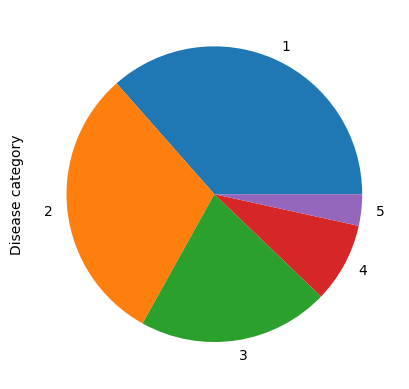

In [6]:
# 分類標籤
CLASSES = ["Phonotrauma", "Incomplete glottic closure", "Vocal palsy", "Neoplasm", "Normal"]
df['Disease category'].value_counts().plot.pie()

下面block可優化

In [7]:
# 樣本權重 sample weight  (for imbalance data)
df['sample_weight'] = class_weight.compute_sample_weight('balanced', y=df['Disease category'])
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,sample_weight
1,0600ve0,1,69,2,1,1,1,1,0,0,...,1,3,0,0,0,0,0,1,19.0,0.657391
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,4,0,1,0,0,0,0,16.0,0.547826
9,11019sl,1,51,1,1,1,0,1,1,0,...,3,2,0,1,0,0,0,0,14.0,0.547826
14,0402svh,1,91,4,0,0,0,0,0,0,...,1,4,0,0,0,0,0,0,7.0,2.290909
15,0T0018b,1,74,3,0,1,0,1,0,0,...,1,3,0,1,0,0,0,0,15.0,0.956962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,1,35,1,1,0,1,1,1,1,...,2,1,0,0,0,0,0,0,28.0,0.547826
994,0T022un,1,52,3,1,1,0,0,0,0,...,1,3,0,0,0,0,0,0,37.0,0.956962
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,1,4,1,1,1,0,0,0,21.0,0.956962
996,1201pkr,1,40,4,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,21.0,2.290909


In [8]:
# class weight (for imbalance data)
cw = class_weight.compute_class_weight('balanced', classes=np.array([1,2,3,4,5]), y=df['Disease category'])
class_weight_dict = dict(enumerate(cw))
print("CLASSES:", CLASSES)
print("class_weight_dict =", class_weight_dict)

CLASSES: ['Phonotrauma', 'Incomplete glottic closure', 'Vocal palsy', 'Neoplasm', 'Normal']
class_weight_dict = {0: 0.5478260869565217, 1: 0.6573913043478261, 2: 0.9569620253164557, 3: 2.290909090909091, 4: 5.815384615384615}


## 1.1 清理缺失值 (NA)

In [9]:
# PPD (一天幾包菸)
df['PPD'] = df['PPD'].fillna(0)  # 缺值補0
print("'PPD' na number =", df['PPD'].isna().sum())

'PPD' na number = 0


<Axes: >

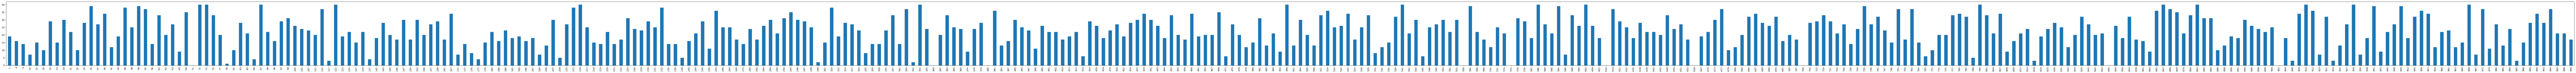

In [10]:
df['Voice handicap index - 10'].plot(kind = 'bar', figsize = (200, 5))

下面Block可優化

In [11]:
# Voice handicap index - 10  (VHI-10嗓音障礙指標) 0-40
print(df['Voice handicap index - 10'].describe())
df.loc[df['Voice handicap index - 10'].isna(), 'Voice handicap index - 10'] = 23  # 缺值補23(中位數)
print("'Voice handicap index - 10' na number =", df['Voice handicap index - 10'].isna().sum())

count    374.000000
mean      22.729947
std        9.901624
min        0.000000
25%       16.000000
50%       23.000000
75%       30.000000
max       40.000000
Name: Voice handicap index - 10, dtype: float64
'Voice handicap index - 10' na number = 0


<Axes: >

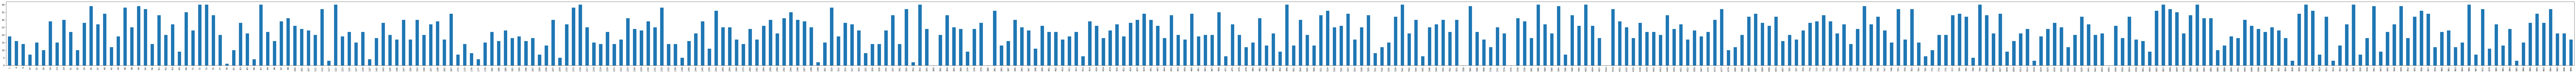

In [12]:
df['Voice handicap index - 10'].plot(kind = 'bar', figsize = (200, 5))

## 1.2 處理 類別變項 (Categorical Feature) --> one-hot encoding
其他方法：https://axk51013.medium.com/%E4%B8%8D%E8%A6%81%E5%86%8D%E5%81%9Aone-hot-encoding-b5126d3f8a63  

In [13]:
print("所有的欄位：", df.columns)

所有的欄位： Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'sample_weight'],
      dtype='object')


In [14]:
# 類別欄位 處理成one-hot (是非題的變因不處理)
categorical_columns = ['Sex', 'Smoking', 'Diurnal pattern', 'Onset of dysphonia ', 'Occupational vocal demand']
df_trans = pd.get_dummies(df, columns=categorical_columns)
df_trans

,ID,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Diurnal pattern_4,Onset of dysphonia _1,Onset of dysphonia _2,Onset of dysphonia _3,Onset of dysphonia _4,Onset of dysphonia _5,Occupational vocal demand_1,Occupational vocal demand_2,Occupational vocal demand_3,Occupational vocal demand_4
1,0600ve0,69,2,1,1,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0402jvt,87,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
9,11019sl,51,1,1,1,0,1,1,0,0,...,1,0,1,0,0,0,0,1,0,0
14,0402svh,91,4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
15,0T0018b,74,3,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,35,1,1,0,1,1,1,1,0,...,1,0,1,0,0,0,1,0,0,0
994,0T022un,52,3,1,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
995,0G00ftn,75,3,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
996,1201pkr,40,4,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [15]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 1 to 999
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           378 non-null    object 
 1   Age                          378 non-null    int64  
 2   Disease category             378 non-null    int64  
 3   Narrow pitch range           378 non-null    int64  
 4   Decreased volume             378 non-null    int64  
 5   Fatigue                      378 non-null    int64  
 6   Dryness                      378 non-null    int64  
 7   Lumping                      378 non-null    int64  
 8   heartburn                    378 non-null    int64  
 9   Choking                      378 non-null    int64  
 10  Eye dryness                  378 non-null    int64  
 11  PND                          378 non-null    int64  
 12  PPD                          378 non-null    float64
 13  Drinking            

## 1.3 處理 連續變項 (Continuous Feature)

In [16]:
# 正規化(Normalization) [0.0 ~ 1.0]
df_trans['Age'] = df['Age'] / 100
df_trans['PPD'] = df['PPD'] / 2
df_trans['Drinking'] = df['Drinking'] / 2
df_trans['frequency'] = df['frequency'] / 3
df_trans['Noise at work'] = (df['Noise at work'] - 1) / 2
df_trans['Occupational vocal demand'] = (4 - df['Occupational vocal demand']) / 3
df_trans['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40
df_trans.describe()

,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,Eye dryness,...,Onset of dysphonia _1,Onset of dysphonia _2,Onset of dysphonia _3,Onset of dysphonia _4,Onset of dysphonia _5,Occupational vocal demand_1,Occupational vocal demand_2,Occupational vocal demand_3,Occupational vocal demand_4,Occupational vocal demand
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,0.519471,2.121693,0.402116,0.396825,0.423280,0.436508,0.351852,0.063492,0.195767,0.145503,...,0.275132,0.396825,0.179894,0.055556,0.092593,0.349206,0.280423,0.264550,0.105820,0.624339
std,0.155934,1.105091,0.490975,0.489888,0.494734,0.496610,0.478181,0.244169,0.397316,0.353074,...,0.447173,0.489888,0.384608,0.229365,0.290245,0.477351,0.449801,0.441678,0.308015,0.337247
min,0.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.390000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
50%,0.530000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
75%,0.637500,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,0.970000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.4 處理 目標欄位 (target)

In [17]:
df_trans = pd.get_dummies(df_trans, columns=['Disease category'])
df_trans

,ID,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,Eye dryness,...,Occupational vocal demand_1,Occupational vocal demand_2,Occupational vocal demand_3,Occupational vocal demand_4,Occupational vocal demand,Disease category_1,Disease category_2,Disease category_3,Disease category_4,Disease category_5
1,0600ve0,0.69,1,1,1,1,0,0,1,0,...,0,0,1,0,0.333333,0,1,0,0,0
4,0402jvt,0.87,0,0,0,0,0,0,0,0,...,0,0,0,1,0.000000,1,0,0,0,0
9,11019sl,0.51,1,1,0,1,1,0,0,0,...,0,1,0,0,0.666667,1,0,0,0,0
14,0402svh,0.91,0,0,0,0,0,0,0,1,...,0,0,0,1,0.000000,0,0,0,1,0
15,0T0018b,0.74,0,1,0,1,0,0,0,1,...,0,0,1,0,0.333333,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1201pl2,0.35,1,0,1,1,1,1,0,0,...,1,0,0,0,1.000000,1,0,0,0,0
994,0T022un,0.52,1,1,0,0,0,0,1,1,...,0,0,1,0,0.333333,0,0,1,0,0
995,0G00ftn,0.75,0,0,0,0,0,0,1,0,...,0,0,0,1,0.000000,0,0,1,0,0
996,1201pkr,0.40,0,0,1,0,0,0,1,0,...,0,1,0,0,0.666667,0,0,0,1,0


In [18]:
df_trans.columns

Index(['ID', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'PPD', 'Drinking', 'frequency', 'Noise at work', 'Diabetes',
       'Hypertension', 'CAD', 'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'sample_weight', 'Sex_1', 'Smoking_0',
       'Smoking_1', 'Smoking_2', 'Smoking_3', 'Diurnal pattern_1',
       'Diurnal pattern_2', 'Diurnal pattern_3', 'Diurnal pattern_4',
       'Onset of dysphonia _1', 'Onset of dysphonia _2',
       'Onset of dysphonia _3', 'Onset of dysphonia _4',
       'Onset of dysphonia _5', 'Occupational vocal demand_1',
       'Occupational vocal demand_2', 'Occupational vocal demand_3',
       'Occupational vocal demand_4', 'Occupational vocal demand',
       'Disease category_1', 'Disease category_2', 'Disease category_3',
       'Disease category_4', 'Disease category_5'],
      dtype='object')

In [19]:
# 特徵欄位 ('ID'不是特徵)
feature_columns = ['Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'PPD', 'Drinking', 'frequency', 'Noise at work', 'Diabetes',
       'Hypertension', 'CAD', 'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10', 'Sex_1', 'Smoking_0', 'Smoking_1',
       'Smoking_2', 'Smoking_3', 'Diurnal pattern_1', 'Diurnal pattern_2',
       'Diurnal pattern_3', 'Diurnal pattern_4', 'Onset of dysphonia _1',
       'Onset of dysphonia _2', 'Onset of dysphonia _3',
       'Onset of dysphonia _4', 'Onset of dysphonia _5',
       'Occupational vocal demand_1', 'Occupational vocal demand_2',
       'Occupational vocal demand_3', 'Occupational vocal demand_4',
       'Occupational vocal demand']
# 分類目標欄位
target_columns = ['Disease category_1', 'Disease category_2', 'Disease category_3', 'Disease category_4', 'Disease category_5']

print("特徵欄位數量 =", len(feature_columns))
print("目標欄位數量 =", len(target_columns))

特徵欄位數量 = 40
目標欄位數量 = 5


## 1.5 資料及分割 (train/valid)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [20]:
# 按診斷分類 切分 train/valid
train_index, valid_index = train_test_split(df_trans.index, train_size=0.8, random_state=333, stratify=df['Disease category'])
print('train_index shape =', train_index.shape)
print('valid_index shape =', valid_index.shape)

train_index shape = (302,)
valid_index shape = (76,)


## 1.6 樣本產生器(generator)
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [21]:
# define tensorflow function
def train_preprocessing(idx):
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        feats = df_trans.loc[idx, feature_columns].values
        label = df_trans.loc[idx, target_columns].values
        sample_weight = df_trans.loc[idx, 'sample_weight']       
        return feats, label, sample_weight

    feats, label, sample_weight = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32, tf.float32])
    return feats, label, sample_weight  # tensor output

def valid_preprocessing(idx):  # same as train_preprocessing but without augmentation and sample_weight
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        feats = df_trans.loc[idx, feature_columns].values
        label = df_trans.loc[idx, target_columns].values
        return feats, label
        
    feats, label = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32])
    return feats, label  # tensor output

# tf function test:
idx = np.random.choice(df.index, size=1)[0]  # 隨機選一個資料索引
X, y, sw = train_preprocessing(idx)
print(f"X shape={X.shape} dtype={X.dtype.name}")
print("y =", y)
print("sample_weight =", sw)

X shape=(40,) dtype=float32
y = tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
sample_weight = tf.Tensor(0.95696205, shape=(), dtype=float32)


In [22]:
# prepare dataset as generator
batch_size = 64
autotune = tf.data.experimental.AUTOTUNE

train_generator = tf.data.Dataset.from_tensor_slices(train_index)  # train index
train_generator = train_generator.shuffle(len(train_index), reshuffle_each_iteration=True) \
                                .map(train_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

valid_generator = tf.data.Dataset.from_tensor_slices(valid_index)  # valid index
valid_generator = valid_generator.map(valid_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

# train_generator test:
for batch_x, batch_y, batch_sw in train_generator:
    print("batch_x shape:", batch_x.shape)
    print("batch_y shape:", batch_y.shape)
    print("batch_sw shape:", batch_sw.shape)
    break

batch_x shape: (64, 40)
batch_y shape: (64, 5)
batch_sw shape: (64,)


2023-05-17 16:58:15.303072: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [302]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:58:15.303262: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [302]
	 [[{{node Placeholder/_0}}]]


# 2 模型 Model

In [23]:
def build_model(feature_num, num_classes=5):
    inputs = layers.Input(shape=(feature_num, ), name="feats")

    # MLP
    x = layers.Dense(64, activation="relu", name="dense")(inputs)
    x = layers.Dense(64, activation="relu", name = 'dense_1')(x)
    x = layers.Dropout(0.1, name = 'dropout')(x)
    
    logits = layers.Dense(num_classes, name="logits")(x)

    model = Model(inputs=inputs, outputs=logits, name=f"feat{feature_num}_Unisex_Sex1")  # <-- 為模型命名(存檔資料夾名稱)
    return model

# Build model.
K.clear_session()
model = build_model(feature_num=len(feature_columns))
model.summary(line_length=160)

Model: "feat40_Unisex_Sex1"
________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                           Output Shape                                                    Param #                 
 feats (InputLayer)                                                     [(None, 40)]                                                    0                       
                                                                                                                                                                
 dense (Dense)                                                          (None, 64)                                                      2624                    
                                                                                                                                                                
 dense

In [24]:
# 看看設計架構
plot_model(model, to_file="/tmp/model.png", show_shapes=True, show_dtype=True, show_layer_names=True, dpi=48)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())    
        return recall 
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.AUC(name='auc'), 
                       f1, 
                       ])

## MLP讀取

In [26]:
# 讀取模型存檔
h5_file_path = "/Users/zhongyongting/1112/ai_workshop/model/feat40_Unisex_Sex1/best_model.h5"  # <-- 確認模型檔案存放的路徑
model1 = load_model(h5_file_path, compile=False)
model1.trainable = False  # 凍結所有可訓練權重
model1.summary()

Model: "feat40_Unisex_Sex1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feats (InputLayer)          [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 64)                2624      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 logits (Dense)              (None, 5)                 325       
                                                                 
Total params: 7109 (27.77 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7109 (27.77 KB)
_________________________________________________________________


## CNN讀取

In [27]:
# 讀取模型存檔
h5_file_path = "/Users/zhongyongting/1112/ai_workshop/model/CNN_Unisex_Sex1/best_model.h5"  # <-- 確認模型檔案存放的路徑
model2 = load_model(h5_file_path, compile=False)
model2.trainable = False  # 凍結所有可訓練權重
model2.summary()

Model: "wav40-res2D_16_32_64_128_128-AP3_FlatD256D128-D5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wave (InputLayer)           [(None, 40, 87, 1)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 40, 87, 16)           160       ['wave[0][0]']                
                                                                                                  
 activation (Activation)     (None, 40, 87, 16)           0         ['conv2d_1[0][0]']            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 40, 87, 16)           2320      ['activation[0][0]']          
                                                   

## 融合兩個模型

In [28]:
def build_model(num_classes=5):
    # MLP pretrained-model
    x1 = model1.get_layer('dense').output  # 分類頭前面一層的輸出

    # # CNN pretrained model
    x2 = model2.get_layer('flatten').output  # 分類頭前面一層的輸出

    # merge
    x = layers.Concatenate(axis=1, name="merge_concat")([x1, x2])
    x = layers.Dense(units=128, activation="relu", name="merge_dense1")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(units=128, activation="relu", name="merge_dense2")(x)
    x = layers.Dropout(0.1)(x)

    logits = layers.Dense(num_classes, name="logits")(x)

    return Model(inputs=[model1.input, model2.input], 
                 outputs=logits, name=f"pretrain-mlp41-cnn128x87-D128O1x2-D5")  # <-- 為模型命名(存檔資料夾名稱)


# Build model.
K.clear_session()
model = build_model()
model.summary(line_length=160)

Model: "pretrain-mlp41-cnn128x87-D128O1x2-D5"
________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                   Output Shape                                    Param #         Connected to                                    
 wave (InputLayer)                              [(None, 40, 87, 1)]                             0               []                                              
                                                                                                                                                                
 conv2d_1 (Conv2D)                              (None, 40, 87, 16)                              160             ['wave[0][0]']                                  
                                                                                                                                                     

In [33]:
# 看看設計架構
plot_model(model, to_file="/tmp/model.png", show_shapes=True, show_dtype=True, show_layer_names=True, dpi=48)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())    
        return recall 
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.AUC(name='auc'), 
                       f1, 
                       ])

# 3 訓練 Training

In [31]:
# 建立模型儲存資料夾
model_dir = f"{my_working_root}/model/{model.name}"  # <-- 指定模型儲存的資料夾
os.makedirs(model_dir, exist_ok=True)

# Define callbacks
mc = callbacks.ModelCheckpoint(filepath= model_dir + '/best_model.h5', 
                               monitor='val_f1', mode='max', save_best_only=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=15)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30)

# 開始訓練
EPOCHS = 300
history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=valid_generator, 
                    callbacks=[mc, rl, es], 
                    )

Epoch 1/300


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "pretrain-mlp41-cnn128x87-D128O1x2-D5" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=<unknown> dtype=float32>]


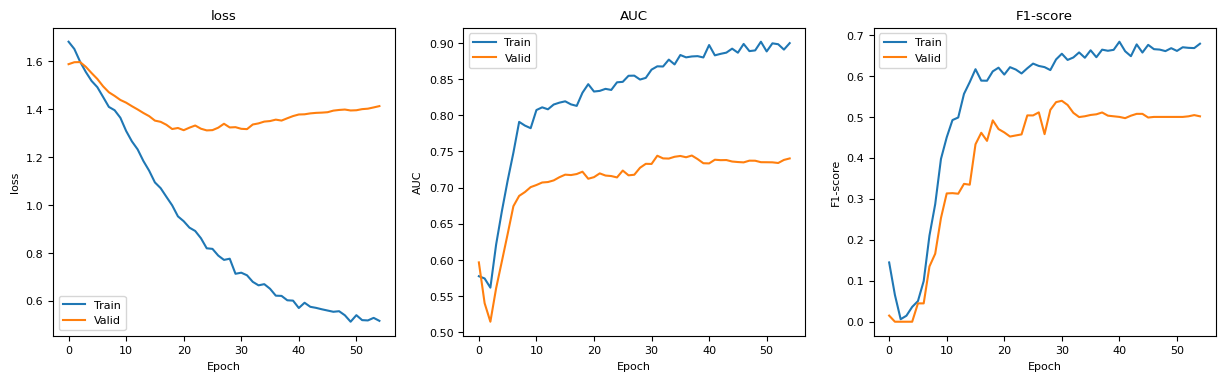

In [ ]:
#@title 訓練曲線
plt.rcParams.update({'font.size': 8})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot training & validation accuracy values
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('loss')
ax1.set(ylabel='loss', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='lower left')

# Plot training & validation loss values
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('AUC')
ax2.set(ylabel='AUC', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation F1-score values
ax3.plot(history.history['f1'])
ax3.plot(history.history['val_f1'])
ax3.set_title('F1-score')
ax3.set(ylabel='F1-score', xlabel='Epoch')
ax3.legend(['Train', 'Valid'], loc='upper left')

plt.show()

In [ ]:
# 儲存模型 save model
h5_file_path = model_dir + "/epoch_end.h5"
model.save(h5_file_path)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 4 評估 Evaluation

In [ ]:
# 讀取模型存檔
h5_file_path = model_dir + "/best_model.h5"
# h5_file_path = model_dir + "/epoch_end.h5"
model = load_model(h5_file_path, compile=False)

In [ ]:
# 預測 驗證集 predict valid_set eagerly
y_true = []
y_pred = []
for x, y in valid_generator:
    y_true.append(y)
    pred = model(x, training=False).numpy()
    y_pred.append(pred)
    print(".", end="")
print("Done!")

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

..Done!
y_true shape: (76, 5)
y_pred shape: (76, 5)


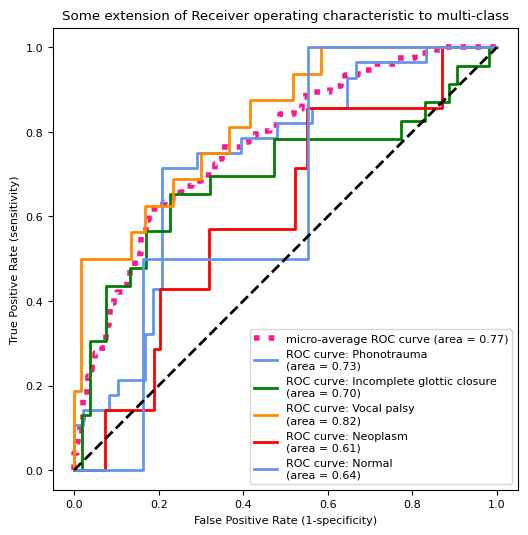

In [ ]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = False  #@param {type:"boolean"}

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
lw = 2
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # 計算 微觀平均曲線
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # 計算 宏觀平均曲線
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 640x480 with 0 Axes>

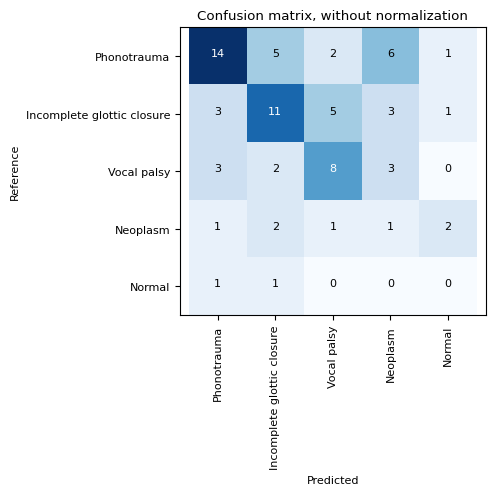

<Figure size 640x480 with 0 Axes>

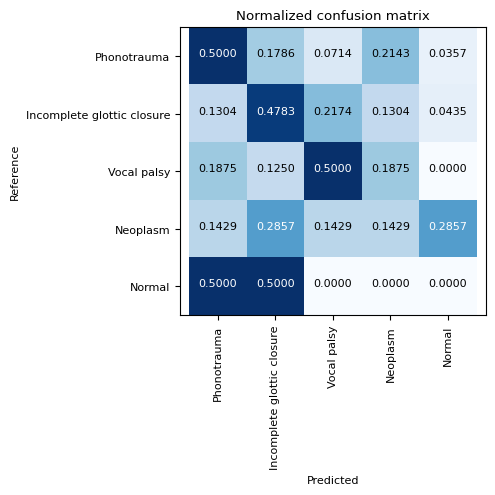

In [ ]:
#@title 畫出 混淆矩陣 confusion matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 8})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Reference')
    ax.set_xlabel('Predicted')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))  #
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
# Plot normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
#@title 多分類報告 classification report
report = classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES, digits=4)
print(report)

                            precision    recall  f1-score   support

               Phonotrauma     0.6364    0.5000    0.5600        28
Incomplete glottic closure     0.5238    0.4783    0.5000        23
               Vocal palsy     0.5000    0.5000    0.5000        16
                  Neoplasm     0.0769    0.1429    0.1000         7
                    Normal     0.0000    0.0000    0.0000         2

                  accuracy                         0.4474        76
                 macro avg     0.3474    0.3242    0.3320        76
              weighted avg     0.5053    0.4474    0.4721        76



In [ ]:
#@title UAR (Unweighted Average Recall)
uar = recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
print("Validation UAR (Unweighted Average Recall) :", uar)

Validation UAR (Unweighted Average Recall) : 0.324223602484472


# 5 預測 Prediction
對測試資料作答 (public dataset / private dataset)

In [ ]:
# 讀取資料表
df = pd.read_csv("/Users/zhongyongting/1112/ai_workshop/Data/Public dataset/test_datalist_public.csv")
df

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,1301skj,2,27,0,1,1,1,1,0,0,...,2,3,1,0,0,0,0,0,0,30.0
1,1100j0u,1,50,0,0,0,0,0,0,0,...,1,2,2,0,1,0,0,0,0,30.0
2,0G00r5c,1,41,1,1,0,0,0,0,0,...,5,2,3,0,0,0,0,0,0,29.0
3,1202v5m,2,48,1,0,0,1,1,0,0,...,2,1,4,0,0,0,0,0,0,5.0
4,0C01365,2,43,0,1,0,1,0,1,1,...,1,2,1,0,0,1,0,0,0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0C0147g,2,39,1,0,0,0,0,0,0,...,2,2,2,0,0,0,0,0,0,30.0
496,13021ib,2,58,0,0,1,1,0,1,0,...,2,3,1,0,0,0,0,0,0,30.0
497,110049h,1,72,0,1,1,0,0,0,0,...,3,1,3,0,1,0,0,0,0,32.0
498,0T01khc,2,60,1,0,0,0,1,0,0,...,2,2,4,0,0,0,1,0,0,3.0


In [ ]:
grouped = df.groupby(df['Sex'])
df_Sex1 = grouped.get_group(1)

In [ ]:
# 讀取模型存檔
h5_file_path = "/Users/zhongyongting/1112/ai_workshop/model/feat40_Unisex_Sex1/best_model.h5"  # <-- 確認模型檔案存放的路徑
model = load_model(h5_file_path, compile=False)

In [ ]:
# 1.1 添加音檔路徑：檔案名稱為 {ID}.wav
test_voice_dir = "/Users/zhongyongting/1112/ai_workshop/Data/Public dataset/test_data_public"
df_Sex1['path'] = df_Sex1['ID'].map(lambda x: f"{test_voice_dir}/{x}.wav")
df_Sex1

/var/folders/fv/8l150xdd1s9g5kp4hdz1c8c40000gn/T/ipykernel_41683/1274481953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Sex1['path'] = df_Sex1['ID'].map(lambda x: f"{test_voice_dir}/{x}.wav")


,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,path
1,1100j0u,1,50,0,0,0,0,0,0,0,...,2,2,0,1,0,0,0,0,30.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
2,0G00r5c,1,41,1,1,0,0,0,0,0,...,2,3,0,0,0,0,0,0,29.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
5,1302gp2,1,50,1,1,1,0,1,0,0,...,2,1,0,0,0,0,0,0,30.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
6,0T00ted,1,31,1,1,1,1,0,1,1,...,1,1,0,0,0,0,0,0,38.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
9,0W00632,1,60,0,0,0,1,1,0,0,...,1,3,0,1,0,0,0,0,20.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1300hnu,1,32,1,1,1,1,1,0,0,...,2,1,0,0,0,0,0,0,24.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
484,1301s8k,1,61,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,13.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
489,0H010k0,1,64,0,1,0,1,0,0,0,...,2,1,0,0,0,0,0,0,21.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
491,0T02iml,1,48,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,10.0,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...


In [ ]:
# 樣本產生器(generator)
fix_length = 22050 * 2  # 限制音訊長度 (sampling_rate * 2 sec)

def test_preprocessing(idx):  # same as valid_preprocessing but without label
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        feats = df_trans.loc[idx, feature_columns].values
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        feats2D = wav_to_mel_spec(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        feats2D = feats2D[:, :, np.newaxis]  # add channel
        return feats, feats2D

    feats, feats2D = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32])
    return {'feats':feats, 'wave':feats2D}  # tensor output

test_generator = tf.data.Dataset.from_tensor_slices(df.index)  # all test index
test_generator = test_generator.map(test_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size=32) \
                                .prefetch(2)

# test_generator test:
for batch_x in test_generator:
    print(f"batch_x['feats'] shape={batch_x['feats'].shape} dtype={batch_x['feats'].dtype.name}")
    print(f"batch_x['wave'] shape={batch_x['wave'].shape} dtype={batch_x['wave'].dtype.name}")
    break

2023-05-17 16:29:39.517544: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [500]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:29:39.531960: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: KeyError: 2
Traceback (most recent call last):

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item

  File "pandas/_libs/hashta

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 0
Traceback (most recent call last):

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 2263, in pandas._libs.hashtable.Int64HashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 2273, in pandas._libs.hashtable.Int64HashTable.get_item

KeyError: 0


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/var/folders/fv/8l150xdd1s9g5kp4hdz1c8c40000gn/T/__autograph_generated_fileys6nqlas.py", line 17, in py_preproc
    feats = ag__.ld(df_trans).loc[ag__.ld(idx), ag__.ld(feature_columns)].values
            ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 1067, in __getitem__
    return self._getitem_tuple(key)
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 1247, in _getitem_tuple
    return self._getitem_lowerdim(tup)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 967, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 1312, in _getitem_axis
    return self._get_label(key, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexing.py", line 1260, in _get_label
    return self.obj.xs(label, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/generic.py", line 4056, in xs
    loc = index.get_loc(key)
          ^^^^^^^^^^^^^^^^^^

  File "/Users/zhongyongting/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3804, in get_loc
    raise KeyError(key) from err

KeyError: 0


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

## 5.2 模型預測

In [ ]:
# 讀取模型存檔
h5_file_path = "/content/model/pretrain-mlp41-cnn128x87-D128O1x2-D5/best_model.h5"  # <-- 確認模型檔案存放的路徑
model = load_model(h5_file_path, compile=False)

In [ ]:
# 取得預測結果
y_pred = model.predict(test_generator)
print("y_pred shape =", y_pred.shape)
y_pred

16/16 [==============================] - 10s 579ms/step
y_pred shape = (500, 5)


array([[ 2.89, -0.47, -1.94, -1.11,  2.35],
       [ 1.75,  2.02,  1.46, -1.34, -1.67],
       [ 1.95,  5.36,  1.59, -3.13, -5.65],
       ...,
       [ 3.5 ,  0.62, -0.64, -0.18, -0.13],
       [ 1.87,  2.15,  0.5 ,  0.82, -0.78],
       [ 2.21,  1.39, -1.33, -3.96,  1.82]], dtype=float32)

In [ ]:
# 轉換為 疾病類別(1-5)
disease_category = np.argmax(y_pred, axis=1) + 1  # 取每筆最高的預測位置 + 1
disease_category

array([1, 2, 2, 1, 2, 1, 3, 2, 1, 1, 1, 1, 5, 1, 4, 3, 3, 2, 5, 1, 3, 1,
       1, 1, 1, 2, 2, 1, 5, 1, 5, 2, 1, 2, 3, 1, 2, 2, 1, 5, 3, 2, 2, 3,
       5, 2, 3, 1, 3, 1, 2, 2, 3, 2, 4, 1, 2, 2, 2, 3, 3, 3, 4, 4, 1, 1,
       4, 4, 3, 1, 2, 2, 4, 3, 3, 2, 3, 2, 1, 3, 1, 1, 3, 4, 1, 4, 5, 3,
       3, 5, 3, 5, 3, 3, 3, 2, 4, 5, 2, 2, 2, 2, 1, 5, 3, 2, 2, 2, 3, 1,
       3, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 4, 1, 2, 3, 4, 1, 1, 5, 1, 5, 5,
       1, 1, 2, 1, 2, 4, 3, 2, 1, 2, 2, 5, 1, 1, 1, 3, 3, 2, 3, 3, 3, 3,
       3, 5, 2, 5, 2, 2, 2, 1, 1, 2, 1, 5, 3, 2, 5, 2, 2, 3, 4, 2, 2, 1,
       4, 3, 1, 2, 1, 2, 4, 1, 5, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 5, 1, 1,
       5, 5, 1, 3, 1, 2, 2, 4, 2, 3, 2, 4, 1, 3, 5, 5, 5, 2, 3, 4, 4, 2,
       2, 2, 1, 2, 2, 3, 1, 5, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1, 1, 4, 3,
       2, 1, 4, 1, 3, 1, 1, 1, 4, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 5, 2, 5,
       2, 5, 1, 2, 1, 2, 2, 3, 4, 5, 3, 1, 2, 2, 1, 2, 2, 3, 2, 1, 3, 2,
       2, 2, 1, 3, 2, 3, 2, 5, 4, 1, 5, 3, 2, 2, 1,

In [ ]:
# 準備競賽 提交檔案 submission
df_submit = pd.DataFrame()
df_submit['ID'] = df['ID']
df_submit['Category'] = disease_category
df_submit

,ID,Category
0,1301skj,1
1,1100j0u,2
2,0G00r5c,2
3,1202v5m,1
4,0C01365,2
...,...,...
495,0C0147g,1
496,13021ib,3
497,110049h,1
498,0T01khc,2


In [ ]:
# 儲存為 .csv
csv_path = "/tmp/submission_public-MultiModal_0511.csv"  # <-- 修改名稱
df_submit.to_csv(csv_path, header=False, index=False, encoding='utf-8')  # 提交的csv格式不含 index 和 欄位

from google.colab import files
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>